# **Modelagem preços de ações com Redes Neurais Recorrentes - LSTM**

Nesse pequeno projeto iremos aplicar uma rede neural artificial para modelar e gerar previsões com séries temporais. A rede neural que usaremos se chama LSTM (ou *Long short-term memory*) e é uma rede neural recorrente, ou seja, ela é uma estrutura de processamento que consegue representar grandes variedades de comportamentos dinâmicos.

As redes neurais recorrentes possuem mecanismos de *loops*, permitindo que haja realimentação de informação e a criação de representações internas e mecanismos de **memória** que permitem armazenar infomações temporais (principalmente de séries temporais). O fato de possuir muitos *loops*, mesmo com um número reduzido de parâmetros, a rede neural pode gerar um comportamento complexo.

A maioria das redes neurais recorrentes possuem problemas de dependência de longo prazo. Problema de denpendência de longo prazo é quando uma rede neural precisa de um contexto maior (mais informações anteriores à atual) para poder gerar uma previsão acurada. As LSTM's não possuem esse problema, pois foram projetadas para evitar esse problema de dependência.

A LSTM é bastante usada para previsões de séries temporais e usaremos ela aqui para modelar dados de preços de ações.

## Dados

Os dados foram extraídos da plataforma *Yahoo* e são os preços das ações da Petróleo Brasileiro S/A (Petrobras) na Bolsa de valores americana. A peoridicidade é diária e vai do dia 1 de janeiro de 2014 até 11 de Novembro de 2024. Aqui, iremos modelar os preços de fechamento das ações *PBR*.


## **yfinance**

O yfinance é uma biblioteca do Python que permite a extração de dados financeiros de várias fontes, como Yahoo Finance, de forma rápida e fácil. Com o yfinance, é possível obter informações atualizadas sobre ações, índices, moedas e muito mais, facilitando a análise e tomada de decisão no mercado financeiro.


In [ ]:
!pip install yfinance
!pip install yfinance --upgrade --no-cache-dir

## Importação das bibliotecas

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

## Importa dos dados

Vamos usar o *DataReader* para extrair os dados da plataforma *Yahoo* com a periodicidade e intervalo que queremos.

In [ ]:
# Fetch data using yfinance
df = yf.download("PBR", start="2004-01-01", end="2024-12-11")

# Print some data to check if it worked
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price                     Adj Close   Close    High     Low    Open    Volume
Ticker                          PBR     PBR     PBR     PBR     PBR       PBR
Date                                                                         
2004-01-02 00:00:00+00:00  1.814949  7.5500  7.6275  7.3675  7.3675   6396800
2004-01-05 00:00:00+00:00  1.947163  8.1000  8.1450  7.7775  7.8125   8442400
2004-01-06 00:00:00+00:00  2.033103  8.4575  8.5425  8.1050  8.1050  13829600
2004-01-07 00:00:00+00:00  2.007261  8.3500  8.7050  8.2825  8.3725  11067600
2004-01-08 00:00:00+00:00  1.977813  8.2275  8.3125  8.1750  8.3125   7467200


## Análise Exploratória dos dados

Podemos ver as 5 primeiras observações dos 5 preços que foram extraídos (de alta, de baixa, de abertura, de fechamento e o de fechamento ajustado) e o volume de ações que foram negociadas no dia.

In [ ]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PBR,PBR,PBR,PBR,PBR,PBR
Date,,,,,,
2004-01-02 00:00:00+00:00,1.814949,7.5500,7.6275,7.3675,7.3675,6396800
2004-01-05 00:00:00+00:00,1.947163,8.1000,8.1450,7.7775,7.8125,8442400
2004-01-06 00:00:00+00:00,2.033103,8.4575,8.5425,8.1050,8.1050,13829600
2004-01-07 00:00:00+00:00,2.007261,8.3500,8.7050,8.2825,8.3725,11067600
2004-01-08 00:00:00+00:00,1.977813,8.2275,8.3125,8.1750,8.3125,7467200


Temos 5252 observações no nosso conjunto de dados.



In [ ]:
df.shape

(5252, 6)

A colunas não possuem nenhum valor faltante.

In [ ]:
df.isna().sum()

,,0
Price,Ticker,
Adj Close,PBR,0
Close,PBR,0
High,PBR,0
Low,PBR,0
Open,PBR,0
Volume,PBR,0


Temos  5 dados do tipo *float* e 1 dado do tipo *int*.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5252 entries, 2004-01-02 00:00:00+00:00 to 2024-11-12 00:00:00+00:00
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, PBR)  5252 non-null   float64
 1   (Close, PBR)      5252 non-null   float64
 2   (High, PBR)       5252 non-null   float64
 3   (Low, PBR)        5252 non-null   float64
 4   (Open, PBR)       5252 non-null   float64
 5   (Volume, PBR)     5252 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 287.2 KB


Abaixo podemos ver a tabela estatística de todas as variáveis.

In [ ]:
df.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PBR,PBR,PBR,PBR,PBR,PBR
count,5252.000000,5252.000000,5252.000000,5252.000000,5252.000000,5.252000e+03
mean,6.676479,19.096164,19.412871,18.772163,19.113575,2.021913e+07
std,4.098931,12.953493,13.190948,12.717588,12.991040,1.372475e+07
min,0.990108,2.900000,2.970000,2.710000,2.880000,1.569600e+06
25%,3.465196,10.330000,10.490000,10.180000,10.347500,1.173945e+07
50%,5.488271,14.675000,14.860000,14.490000,14.690000,1.700535e+07
75%,9.078148,23.596250,23.933749,23.169375,23.564375,2.528838e+07
max,21.075783,75.190002,77.610001,74.540001,76.650002,2.075641e+08


Visualizando as séries de preços e volume de ações.

In [ ]:
df.corr()

,Price,Adj Close,Close,High,Low,Open,Volume
,Ticker,PBR,PBR,PBR,PBR,PBR,PBR
Price,Ticker,,,,,,
Adj Close,PBR,1.000000,0.808397,0.806901,0.809230,0.807442,-0.143818
Close,PBR,0.808397,1.000000,0.999555,0.999562,0.999055,-0.205880
High,PBR,0.806901,0.999555,1.000000,0.999313,0.999572,-0.198873
Low,PBR,0.809230,0.999562,0.999313,1.000000,0.999465,-0.212995
Open,PBR,0.807442,0.999055,0.999572,0.999465,1.000000,-0.205512
Volume,PBR,-0.143818,-0.205880,-0.198873,-0.212995,-0.205512,1.000000


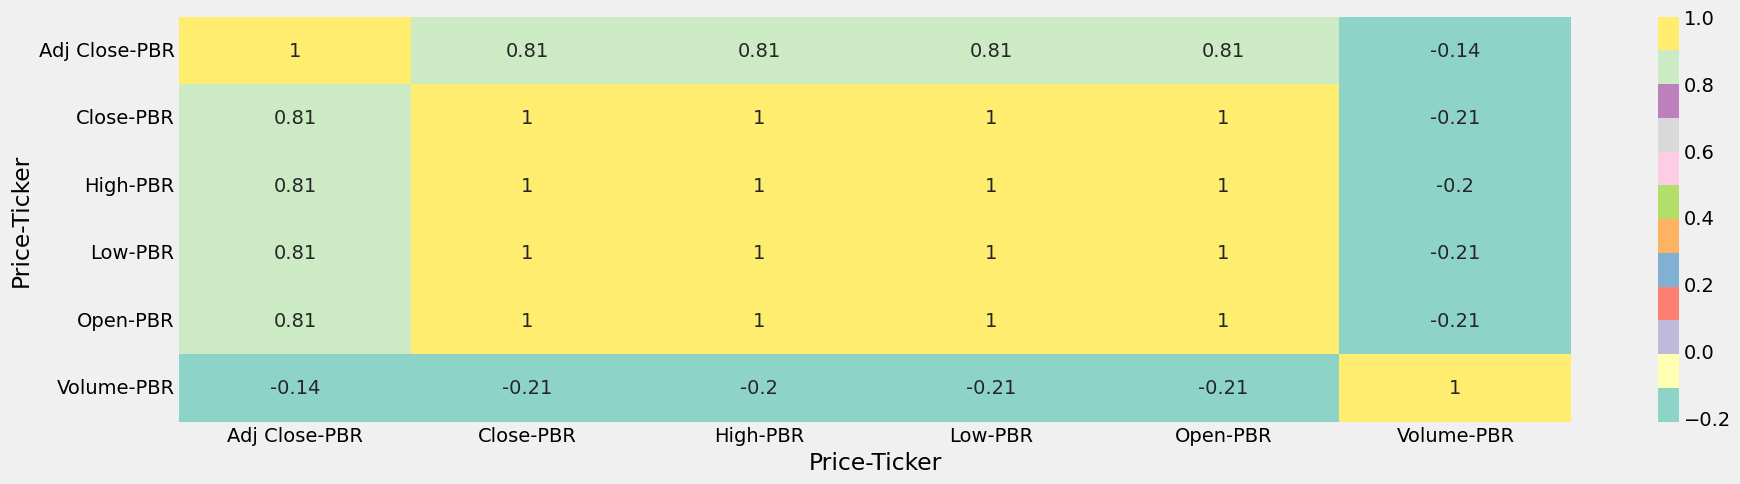

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,5))
correlacao=df.corr()
sns.heatmap(correlacao, annot = True, cmap = "Set3");

<Figure size 2000x1000 with 0 Axes>

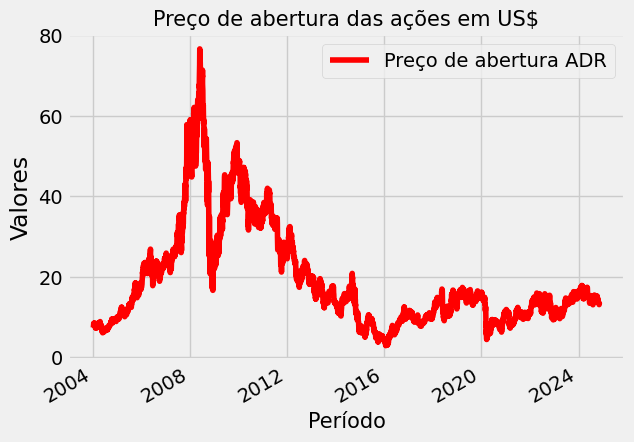

In [ ]:
plt.figure(figsize=(20,10))
df['Open'].plot(color='red')
plt.title('Preço de abertura das ações em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de abertura ADR'])
plt.show()

<Figure size 2000x1000 with 0 Axes>

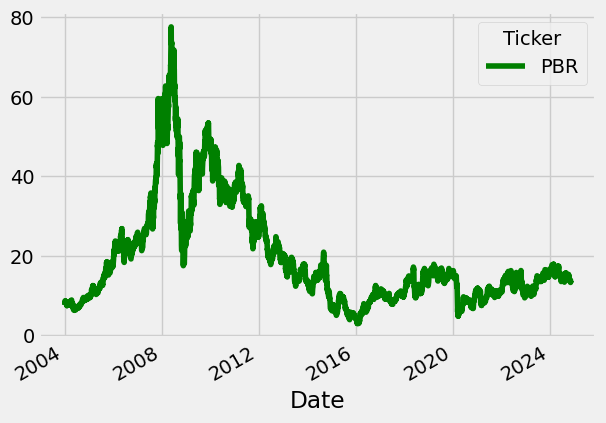

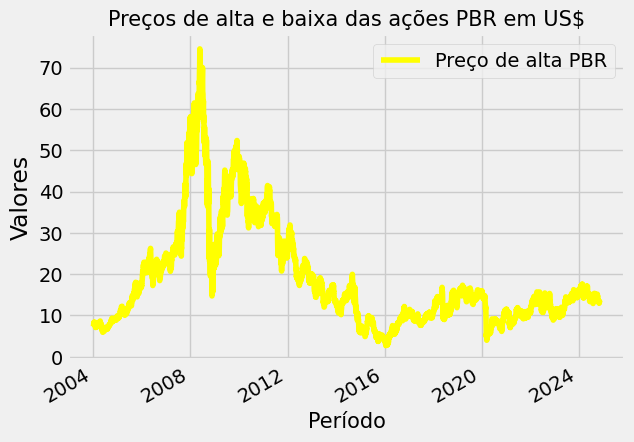

In [ ]:
plt.figure(figsize=(20,10))
df['High'].plot(color='green')
df['Low'].plot(color='yellow')
plt.title('Preços de alta e baixa das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de alta PBR','Preço de baixa PBR'])
plt.show()

<Figure size 2000x1000 with 0 Axes>

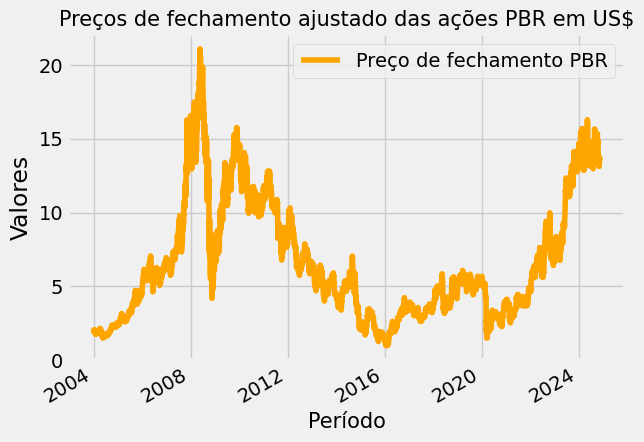

In [ ]:
plt.figure(figsize=(20,10))
df['Adj Close'].plot(color='orange')
plt.title('Preços de fechamento ajustado das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de fechamento PBR'])
plt.show()

<Figure size 2000x1000 with 0 Axes>

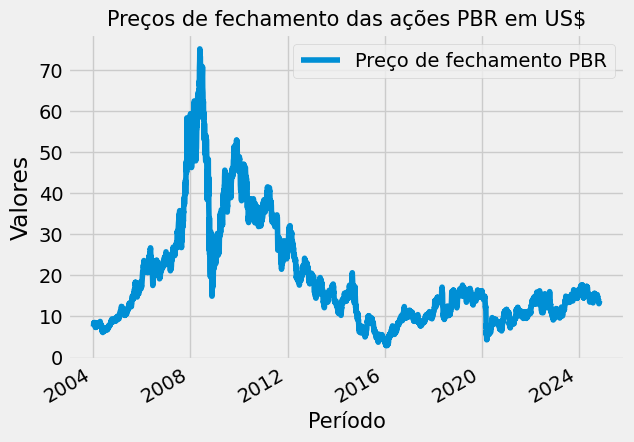

In [ ]:
plt.figure(figsize=(20,10))
df['Close'].plot()
plt.title('Preços de fechamento das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de fechamento PBR'])
plt.show()

<Figure size 2000x1000 with 0 Axes>

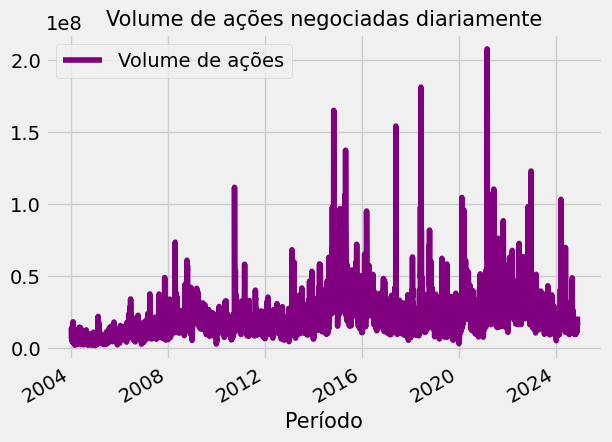

In [ ]:
plt.figure(figsize=(20,10))
df['Volume'].plot(color='purple')
plt.title('Volume de ações negociadas diariamente', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('')
plt.legend(['Volume de ações'])
plt.show()

## Dados de treino

Vamos agora separar os dados de treino. Vamos escolher para os dados de treino 80% da série temporal. Para o treino teremos 4200 observações.

In [ ]:
#Da série vamos extrair apenas os dados de fechamento
data=df.filter(['Close'])
#selecionar seus valores
dataset=data.values
#separa 80% desses dados
training_data_len=math.ceil(len(dataset)*.8)
#e vamos visualizar quantas observações temos
training_data_len

4202

## Transformação dos dados

Precisaremos alterar a escala dos dados para o futuro procedimento de treino e geração de previsões do modelo. Usaremos o método *MinMaxScaler* que colocará os dados em uma escala entre 0 e 1.

In [ ]:
#escalando para o intervalo entre 0 e 1
scaler=MinMaxScaler(feature_range=(0,1))

data = df[['Close']]  # Use double brackets to select 'Close' as a DataFrame, not a Series
dataset = data.values

# Continue with scaling:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.06432425],
       [0.0719325 ],
       [0.07687786],
       ...,
       [0.14912159],
       [0.1482916 ],
       [0.14967492]])

Agora vamos separar os dados em *x* e *y* de treino.

In [ ]:
#criando um dataset de treino
train_data = scaled_data[0:training_data_len,:]
#separando dados de treino e teste
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=61:
    print(x_train)
    print(y_train)
    print()

[array([0.06432425, 0.0719325 , 0.07687786, 0.07539079, 0.07369622,
       0.07386913, 0.07743118, 0.07673952, 0.07355788, 0.0692696 ,
       0.07172499, 0.07784617, 0.07487204, 0.07348872, 0.07418038,
       0.07418038, 0.07386913, 0.07127541, 0.06408216, 0.06155761,
       0.06373634, 0.06484299, 0.06325217, 0.06114262, 0.06397842,
       0.06581131, 0.0680592 , 0.07269331, 0.07362705, 0.07144832,
       0.07058375, 0.06802462, 0.06484299, 0.06487758, 0.06619172,
       0.06397842, 0.06740213, 0.06660672, 0.06778254, 0.07407663,
       0.07452622, 0.07604786, 0.0733158 , 0.07369622, 0.07452622,
       0.07642827, 0.07044542, 0.06799004, 0.07179416, 0.06830128,
       0.0694771 , 0.07127541, 0.07708534, 0.07279707, 0.07165583,
       0.06999585, 0.06965002, 0.06709088, 0.06633006, 0.06722922])]
[0.07158665854132834]

[array([0.06432425, 0.0719325 , 0.07687786, 0.07539079, 0.07369622,
       0.07386913, 0.07743118, 0.07673952, 0.07355788, 0.0692696 ,
       0.07172499, 0.07784617, 0.07

Vamos converter *x_train* e *y_train* para *array numpy*.

In [ ]:
x_train,y_train = np.array(x_train), np.array(y_train)

Em *x_train* temos um *array* com dimensões 4142 x 60.

In [ ]:
x_train.shape

(4142, 60)

Agora vamos redimensionar os dados.

In [ ]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(4142, 60, 1)

## Modelagem dos dados

Agora vamos criar o nosso modelo. Como é uma rede neural teremos camadas de entradas, camadas intermediárias e camadas de saída. Temos o nosso modelo *Sequential* e vamos adicionando as camadas (*LSTM* e *Dense*). As duas primeiras camadas possuem 50 neurônios, a penúltima camada densa (*Dense*) 25 e a última camada tem apenas 1 neurônio que é de onde serão geradas as saídas do modelo, que serão as nossas previsões.

In [ ]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Agora que o nosso modelo foi criado, podemos configurá-lo com a função perda e com as métricas. Aqui usaremos o *adam* que é o método *stochastic gradient descent* ou gradiente estocástico descendente que é um dos métodos de minimização. A métrica de avaliação que usaremos será o *mean_squared_error* ou média dos erros quadrados.

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

Vamos treinar o modelo e usaremos um período de treino ou *epoch*.

In [ ]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

4142/4142 ━━━━━━━━━━━━━━━━━━━━ 129s 30ms/step - loss: 0.0019


## Dados de teste

Aqui vamos criar dois conjuntos de dados de teste *x_test* e *y_test*, uma para aplicar ao modelo treinado e o outro para comparar o resultados das previsões. Faremos, praticamente, a mesma coisa que na seleção dos dados de treino. Vamos separar os dados, mas apenas ao *x_test* transformaremos em um *array numpy*.

In [ ]:
#criando os dados de teste
test_data=scaled_data[training_data_len-60:,:]

#criando x_test e y_test
x_test=[]
y_test=dataset[training_data_len:,:]

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

Convertendo em um *array numpy*.

In [ ]:
x_test=np.array(x_test)

Redimensionando os dados de teste que serão aplicado no modelo para previsão.

In [ ]:
x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

Gerando as previsões com o modelo LSTM e logo em seguida iremos inverter a transformação que fizemos para que os resultados tenham a escala correta.

In [ ]:
predictions=model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


## Avaliação do modelo

Agora teremos que avaliar o desempenho do modelo comparando com os valores reais, para isso usaremos a métrica *RMSE* (*root mean squared error* ) que nos trará a raiz da média do quadrado dos erros. Essa métrica é a mais usada para avaliar modelos de séries temporais.

O nosso resultado de um valor menor que 1. Em alguns trabalhos, para avaliar o desempenho do modelo, comparamos o resultado do *RMSE* com o desvio padrão. No nosso caso o desvio padrão da série de preços de fechamento foi de 2,537612 e nosso *RMSE* de 0.138303. Logo temos um bom resultado gerado pelo modelo.

In [ ]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
print("RMSE do modelo:", rmse)

RMSE do modelo: 0.13830369131905693


In [ ]:
# Calcula o desvio padrão dos valores reais
std_dev = np.std(y_test)
print("Desvio padrão dos valores reais:", std_dev)

Desvio padrão dos valores reais: 2.5376128021297086


In [ ]:
# Comparação entre RMSE e desvio padrão
if rmse < std_dev:
    print("O RMSE é menor que o desvio padrão, indicando um bom ajuste do modelo.")
else:
    print("O RMSE é maior ou igual ao desvio padrão, o que pode indicar um ajuste insuficiente do modelo.")

O RMSE é menor que o desvio padrão, indicando um bom ajuste do modelo.


Vamos uma coluna com os dados de validação e as previsões e comparar os resultados.

In [ ]:
train=data[:training_data_len]

valid=data[training_data_len:]

valid['Predictions'] = predictions

<ipython-input-133-0a36afba6cda>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


Avaliando graficamente, vemos que o resultado das previsões foi muito próximo, para não dizer quase idêntico.

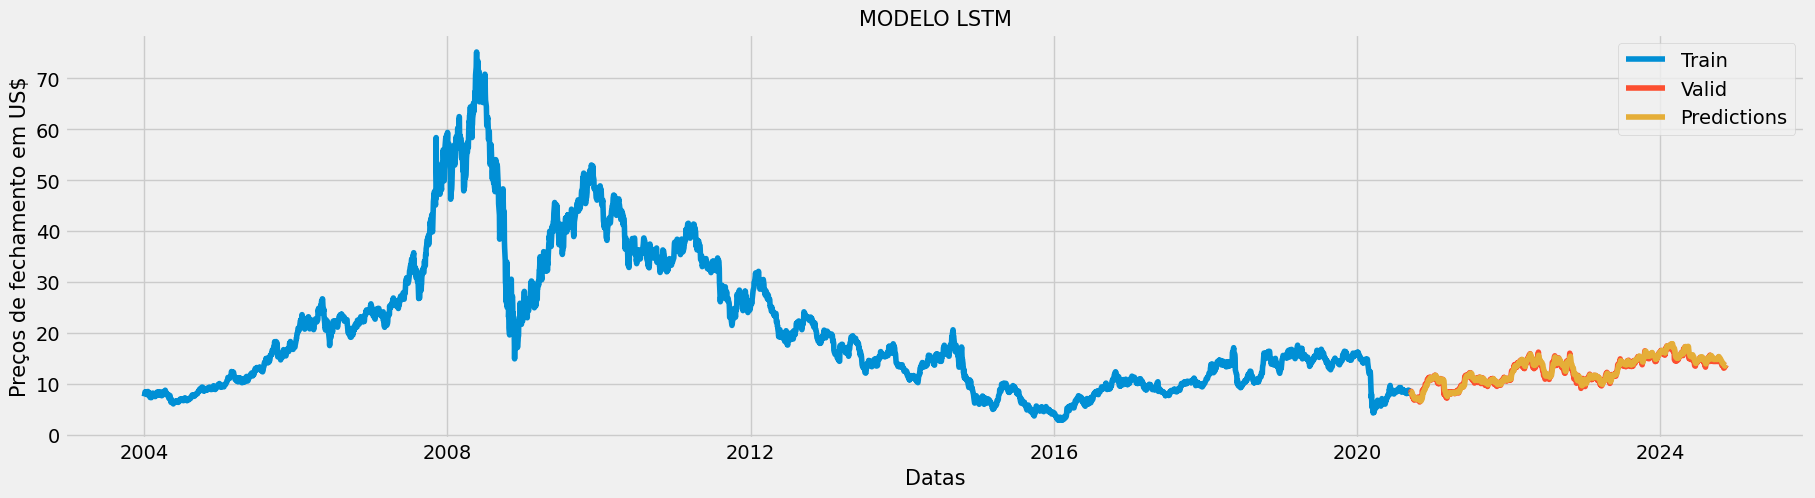

In [ ]:
plt.figure(figsize=(20,5))
plt.title('MODELO LSTM',size=15)
plt.xlabel('Datas',size=15)
plt.ylabel('Preços de fechamento em US$',size=15)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Valid','Predictions'])
plt.show()

Podemos comparar as médias dos valores de validação e das previsões. Vemos que as médias são bem próximas uma das outras.

In [ ]:
print('Média dos valores reais:',valid['Close'].mean())
print('Média das previsões da LSTM:',valid['Predictions'].mean())

Média dos valores reais: Ticker
PBR    12.545867
dtype: float64
Média das previsões da LSTM: 12.684171


Abaixo podemos ver as estatísticas descritivas completas das previsões e dos dados de validação. As médias, desvios-pradrão e quantis possuem os valores próximos.

In [ ]:
valid.describe()

Price,Close,Predictions
Ticker,PBR,
count,1050.000000,1050.000000
mean,12.545867,12.684171
std,2.538822,2.616021
min,6.470000,6.641665
25%,10.720000,10.780733
50%,12.690000,12.891511
75%,14.637500,14.879549
max,17.700001,17.914995


## Conclusão

Esse pequeno projeto vimos as etapas para o tratamento e modeloagem de dados com essa poderosa rede neural recorrente chamada LSTM. A LSTM possui uma capacidade formidável de gerar resultados acurados, pelo seu mecanismo de memória de longo prazo; resultados esses que podem até ter um desempenho melhor do que outros métodos de modelagem de séries temporais (como algoritmos determinísticos ou a modelagem Box-Jenkins).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
Previsões dos 18 dias restantes de novembro 2024: [13.861703, 13.940928, 14.021793, 14.099968, 14.175006]


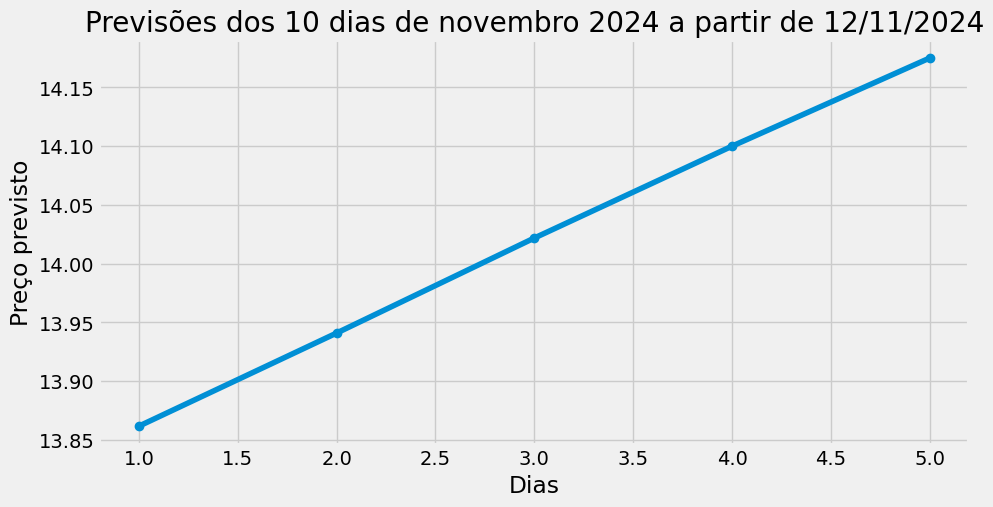

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Número de dias a serem previstos (10 dias de novembro a partir de 13/11/2024)
num_days_to_predict = 5

# Criando uma lista para armazenar previsões futuras
future_predictions = []

# Usando as últimas 5252 observações para iniciar a previsão
last_5252_days = scaled_data[-5252:]
input_data = last_5252_days.reshape((1, last_5252_days.shape[0], 1))

for _ in range(num_days_to_predict):
    # Fazer a previsão para o próximo dia
    predicted_price = model.predict(input_data)

    # Inversão da escala para trazer o valor para a escala original
    predicted_price_original = scaler.inverse_transform(predicted_price)

    # Armazenar a previsão invertida na lista
    future_predictions.append(predicted_price_original[0][0])

    # Atualizar o input_data adicionando a previsão atual e removendo o primeiro valor (janela deslizante)
    input_data = np.append(input_data[:, 1:, :], [[[predicted_price[0][0]]]], axis=1)
    input_data = input_data.reshape((1, 5252, 1))  # Redimensiona para manter as três dimensões

# Exibindo as previsões dos 18 dias restantes de novembro de 2024
print("Previsões dos 18 dias restantes de novembro 2024:", future_predictions)

# Plotando as previsões
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_days_to_predict + 1), future_predictions, marker='o', linestyle='-')
plt.title("Previsões dos 5 dias de novembro 2024 a partir de 12/11/2024")
plt.xlabel("Dias")
plt.ylabel("Preço previsto")
plt.grid(True)
plt.show()
